This notebook combines audio clips into 5-second WAV files and then spectrograms of those WAV files.  These spectrograms are saved together as a numpy array in pickle format.

Also saves a pickle of labels for each spectrogram.

Can be used to generate training and validation data.  

Is currently set up to register 3 classes: 'enough', 'not_enough', 'empty'.

### starting point:

- Assume a folder `recorded_clips`, with subfolders of audio clips:
    - `empties`
    - `enoughs`
    - `notenoughs`
    - `fullbackgrounds_trimmed_5sec`
    
- Can have any number of audio clips.  Only constraint is that the samples are all less than 5 seconds, and the background clips are all exactly 5 seconds.  (Can use `preprocess_audio` and `split_into_2_5sec_files` to turn 10+ second clips into 5 second clips, and `trim_to_5sec` to trim from 5+ seconds to exactly 5.)
- Assume folders `XY_train` and `XY_val`, where the training and validation data will go after generated.

In [1]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from mb_utils import *
%matplotlib inline

import pickle

c:\users\lukewolc\appdata\local\programs\python\python37\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
Using TensorFlow backend.


In [2]:
from importlib import reload
import mb_utils

In [3]:
reload(mb_utils)
from mb_utils import *

In [4]:
Tx = 2754 #5511 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram
Ty = 1375 # The number of time steps in the output of our model

#### Files to work with (may not have all background versions):

In `recorded_clips` folder, have subfolders:

- `backgrounds`: 10 short (1-2 sec) WAV files of background noise
- `enoughs`: 10 WAV files of 'enough', each roughly 1 sec
- `notenoughs`: 10 WAV files of 'not enough', in the 1-3 sec range
- `fullbackgrounds_original`: 10 long (10+ sec) WAV files of background noise
- `fullbackgrounds_trimmed_10sec`: same as original, but trimmed to 10 seconds using `preprocess_audio`
- `fullbackgrounds_trimmed_5sec`: takes ten 10 sec clips and splits them into twenty 5 second clips.

### cutting and trimming clips (don't do unless necessary)

In [197]:
def split_into_2_5sec_files(folder_name, idx):
    filename = 'recorded_clips/{}/{:0>2}.wav'.format(folder_name, idx)
    print(filename)
    padding1 = AudioSegment.silent(duration=5000)
    segment1 = AudioSegment.from_wav(filename)[:5000]
    segment1 = padding1.overlay(segment1)
    segment1 = segment1.set_frame_rate(44100)
    
    padding2 = AudioSegment.silent(duration=5000)
    segment2 = AudioSegment.from_wav(filename)[5000:]
    segment2 = padding2.overlay(segment2)
    segment2 = segment2.set_frame_rate(44100)
    
    # Export as wav
    segment1.export('recorded_clips/{}/{:0>2}.wav'.format(folder_name, idx), format='wav')
    segment2.export('recorded_clips/{}/{:1>2}.wav'.format(folder_name, idx), format='wav')

In [198]:
for i in range(10):
    #split_into_2_5sec_files('fullbackgrounds_trimmed_5sec', i)

recorded_clips/fullbackgrounds_trimmed_5sec/00.wav
recorded_clips/fullbackgrounds_trimmed_5sec/01.wav
recorded_clips/fullbackgrounds_trimmed_5sec/02.wav
recorded_clips/fullbackgrounds_trimmed_5sec/03.wav
recorded_clips/fullbackgrounds_trimmed_5sec/04.wav
recorded_clips/fullbackgrounds_trimmed_5sec/05.wav
recorded_clips/fullbackgrounds_trimmed_5sec/06.wav
recorded_clips/fullbackgrounds_trimmed_5sec/07.wav
recorded_clips/fullbackgrounds_trimmed_5sec/08.wav
recorded_clips/fullbackgrounds_trimmed_5sec/09.wav


In [5]:
def trim_to_5sec(folder_name, idx):
    filename = 'recorded_clips/{}/{:0>2}.wav'.format(folder_name, idx)
    print(filename)
    padding1 = AudioSegment.silent(duration=5000)
    segment1 = AudioSegment.from_wav(filename)[:5000]
    segment1 = padding1.overlay(segment1)
    segment1 = segment1.set_frame_rate(44100)
        
    # Export as wav
    segment1.export('recorded_clips/{}/{:0>2}.wav'.format(folder_name, idx), format='wav')

In [9]:
for i in range(11):
    #trim_to_5sec('fullbackgrounds_trimmed_5sec', i)

recorded_clips/fullbackgrounds_trimmed_5sec_copy/00.wav
recorded_clips/fullbackgrounds_trimmed_5sec_copy/01.wav
recorded_clips/fullbackgrounds_trimmed_5sec_copy/02.wav
recorded_clips/fullbackgrounds_trimmed_5sec_copy/03.wav
recorded_clips/fullbackgrounds_trimmed_5sec_copy/04.wav
recorded_clips/fullbackgrounds_trimmed_5sec_copy/05.wav
recorded_clips/fullbackgrounds_trimmed_5sec_copy/06.wav
recorded_clips/fullbackgrounds_trimmed_5sec_copy/07.wav
recorded_clips/fullbackgrounds_trimmed_5sec_copy/08.wav
recorded_clips/fullbackgrounds_trimmed_5sec_copy/09.wav
recorded_clips/fullbackgrounds_trimmed_5sec_copy/10.wav


### data augmentation (only if necessary)

For each file with filename length less than 8, multiplies it out into `n_pitch_shifts` x `n_time_stretches` copies.

In [6]:
# only augments files with file names less than 8, and adds suffixes to new clips
data_augmentation('recorded_clips/enoughs_da/', n_pitch_shifts=4, n_time_stretches=4)

00.wav
Pitch shifts (half steps):   [ 2.01108752  0.7177423  -0.88292533 -0.76552613]
Time stretches (multiplier): [0.93387914 1.07564343 1.0723305  1.1060334 ]
01.wav
Pitch shifts (half steps):   [ 0.8493005   0.52201074  0.63192317 -1.19996541]
Time stretches (multiplier): [0.86660941 1.16922923 0.82627689 1.0841343 ]
02.wav
Pitch shifts (half steps):   [-0.38036949 -0.7022563   0.20359752  1.26382436]
Time stretches (multiplier): [0.84771137 1.12704102 0.88744931 0.92784621]
03.wav
Pitch shifts (half steps):   [-0.28418222 -0.51889874 -1.15950275  0.02645945]
Time stretches (multiplier): [0.95251619 1.17459151 0.94082043 0.93545963]
04.wav
Pitch shifts (half steps):   [ 0.77112583 -0.16822484  0.16955019  0.63769767]
Time stretches (multiplier): [0.82439805 0.94057667 1.03776608 1.03053709]
05.wav
Pitch shifts (half steps):   [-1.03590836 -0.41486584 -0.51352807  0.60618005]
Time stretches (multiplier): [1.01754322 1.00418381 0.8832709  0.91101709]
06.wav
Pitch shifts (half steps): 

In [7]:
# only augments files with file names less than 8, and adds suffixes to new clips
data_augmentation('recorded_clips/notenoughs_da/', n_pitch_shifts=4, n_time_stretches=4)

00.wav
Pitch shifts (half steps):   [ 0.26689479 -1.11594327 -0.32146003  0.29129365]
Time stretches (multiplier): [0.93780726 0.91829242 1.01268168 1.09807451]
01.wav
Pitch shifts (half steps):   [-0.24154631 -0.12624833  0.52628206 -0.47539943]
Time stretches (multiplier): [1.0666722  1.26963673 1.00799381 0.8435518 ]
02.wav
Pitch shifts (half steps):   [ 0.01650274  1.32486113 -0.33707    -0.21889897]
Time stretches (multiplier): [1.15407461 1.10178443 1.04238716 0.90957641]
03.wav
Pitch shifts (half steps):   [ 0.29896266  0.0043979  -1.51288304  0.15689528]
Time stretches (multiplier): [1.2645016  0.89660719 1.04562621 1.11175856]
04.wav
Pitch shifts (half steps):   [-0.46165063  0.29791898 -0.44760443  0.72190924]
Time stretches (multiplier): [1.00621767 0.98572256 1.0090291  1.05685032]
05.wav
Pitch shifts (half steps):   [ 0.4410868  -0.04182601 -0.7339706   0.53616052]
Time stretches (multiplier): [0.89342828 0.9134677  0.93659004 1.0614738 ]
06.wav
Pitch shifts (half steps): 

In [8]:
# only augments files with file names less than 8, and adds suffixes to new clips
data_augmentation('recorded_clips/empties_da/', n_pitch_shifts=4, n_time_stretches=4)

00.wav
Pitch shifts (half steps):   [-1.17806829  0.3881745  -0.85429139  1.29340672]
Time stretches (multiplier): [0.82893587 1.14672881 1.09348164 0.98308565]
01.wav
Pitch shifts (half steps):   [ 1.06017162  1.25507945 -0.04681213  0.42937468]
Time stretches (multiplier): [0.92730115 1.14925857 1.04183838 0.89803383]
02.wav
Pitch shifts (half steps):   [ 1.01589838 -0.73447025  0.40741322  0.10655571]
Time stretches (multiplier): [1.07442946 1.17014199 0.81636144 0.94911763]
03.wav
Pitch shifts (half steps):   [-1.89086233 -0.07682657  0.04481548  1.44594307]
Time stretches (multiplier): [1.14998168 1.033244   0.96493686 0.97615956]
04.wav
Pitch shifts (half steps):   [-0.49825929 -0.51041189  0.22667789  0.49809105]
Time stretches (multiplier): [0.95185922 1.10957763 0.90442686 1.0342735 ]
05.wav
Pitch shifts (half steps):   [-0.51776997  0.16954924  0.57188666 -0.07902847]
Time stretches (multiplier): [0.80980991 0.93868416 1.14759005 1.00693049]
06.wav
Pitch shifts (half steps): 

### make training dataset and save to disk

In [5]:
# choose with clip folders to use, to use data augmentation or not
clips_location_dict = {'enough': 'recorded_clips/enoughs_da',
                      'not_enough':  'recorded_clips/notenoughs_da',
                      'empty': 'recorded_clips/empties_da',
                      'backgrounds': 'recorded_clips/fullbackgrounds_trimmed_5sec'}

In [6]:
# load audio samples from disk
clips_dict = load_raw_audio(clips_location_dict)

enoughs = clips_dict['enough']
notenoughs = clips_dict['not_enough']
backgrounds = clips_dict['backgrounds']
empties = clips_dict['empty']

enough............187 clips.
not_enough........187 clips.
empty.............204 clips.
backgrounds.......9 clips.


sample:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 2

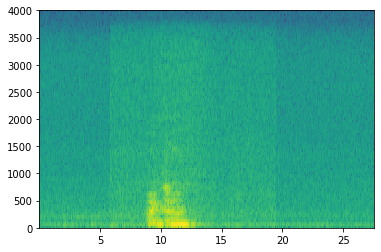

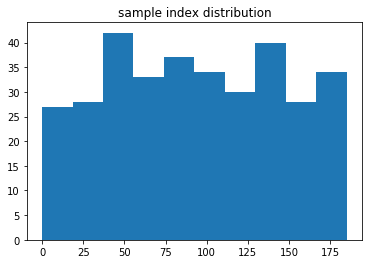

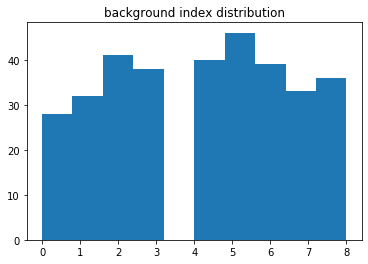

sample:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 2

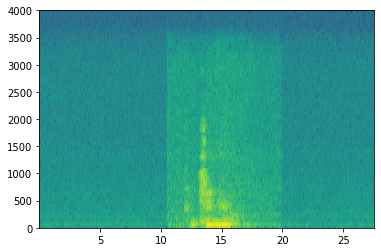

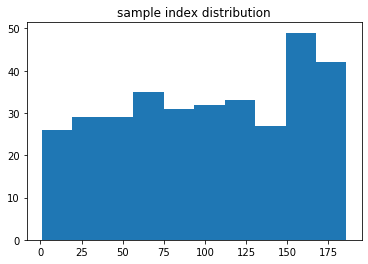

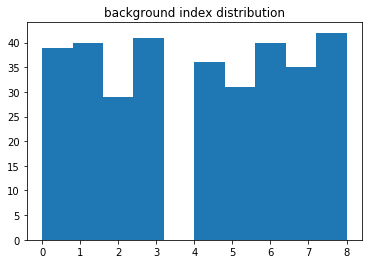

sample:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 2

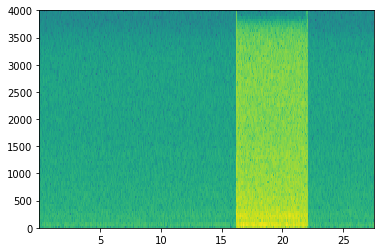

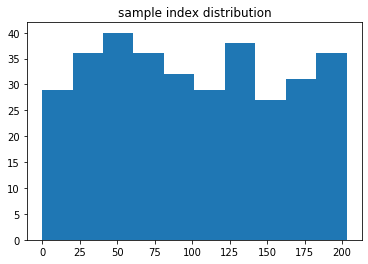

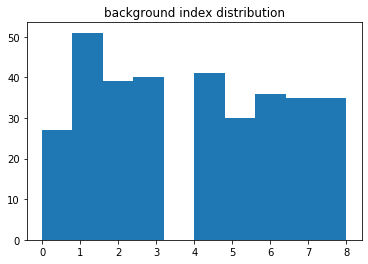

size of X:  (1000, 2754, 101)
length of y: 1000
Features saved to: XY_train/X_1000_5sec_v3.pkl
Labels saved to: XY_train/y_1000_5sec_v3.pkl


In [10]:
# do this repeatedly and change the file_comment, to make multiple datasets
n_enoughs = 333
n_notenoughs = 333
n_empties = 334
file_folder='XY_train'
file_comment='1000_5sec_v3'

X_training, y_training = make_features_and_labels(n_enoughs, n_notenoughs, n_empties, 
                                                  enoughs, notenoughs, empties, backgrounds, Tx, n_freq, Ty)

save_datasets_to_disk(X_training, y_training, file_folder, file_comment)

#### make smaller validation set

sample:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49

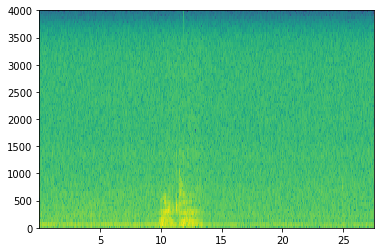

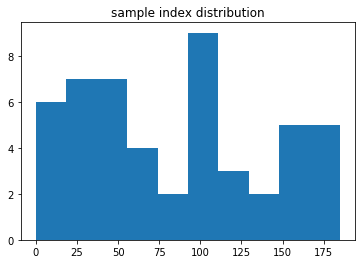

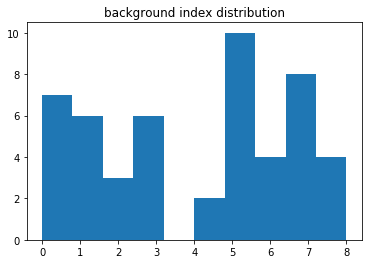

sample:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49

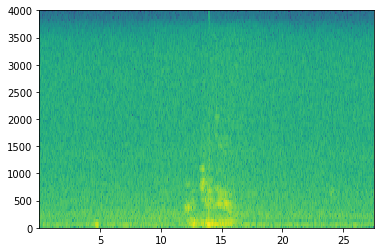

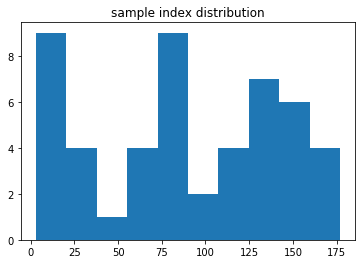

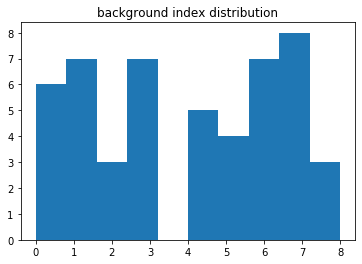

sample:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99

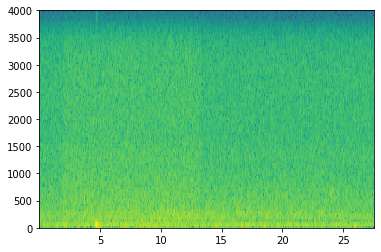

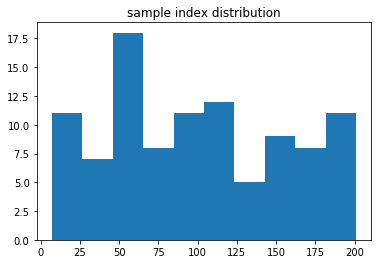

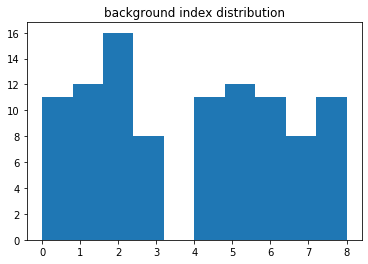

size of X:  (200, 2754, 101)
length of y: 200
Features saved to: XY_val/X_200_5sec_50_50_100.pkl
Labels saved to: XY_val/y_200_5sec_50_50_100.pkl


In [11]:
n_enoughs = 50
n_notenoughs = 50
n_empties = 100
file_folder='XY_val'
file_comment='200_5sec_50_50_100'

X_val, y_val = make_features_and_labels(n_enoughs, n_notenoughs, n_empties, 
                                                  enoughs, notenoughs, empties, backgrounds, Tx, n_freq, Ty)

save_datasets_to_disk(X_val, y_val, file_folder, file_comment)